In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
print(tf.__version__)
print(hub.__version__)
print("gpu available" if tf.config.list_physical_devices("GPU") else "not available")

2.15.0
0.16.1
gpu available


In [ ]:
import pandas as pd
labels_csv=pd.read_csv("/content/drive/MyDrive/CanineID/labels.csv")
labels_csv.describe()

id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126

median breed count :  82.0 





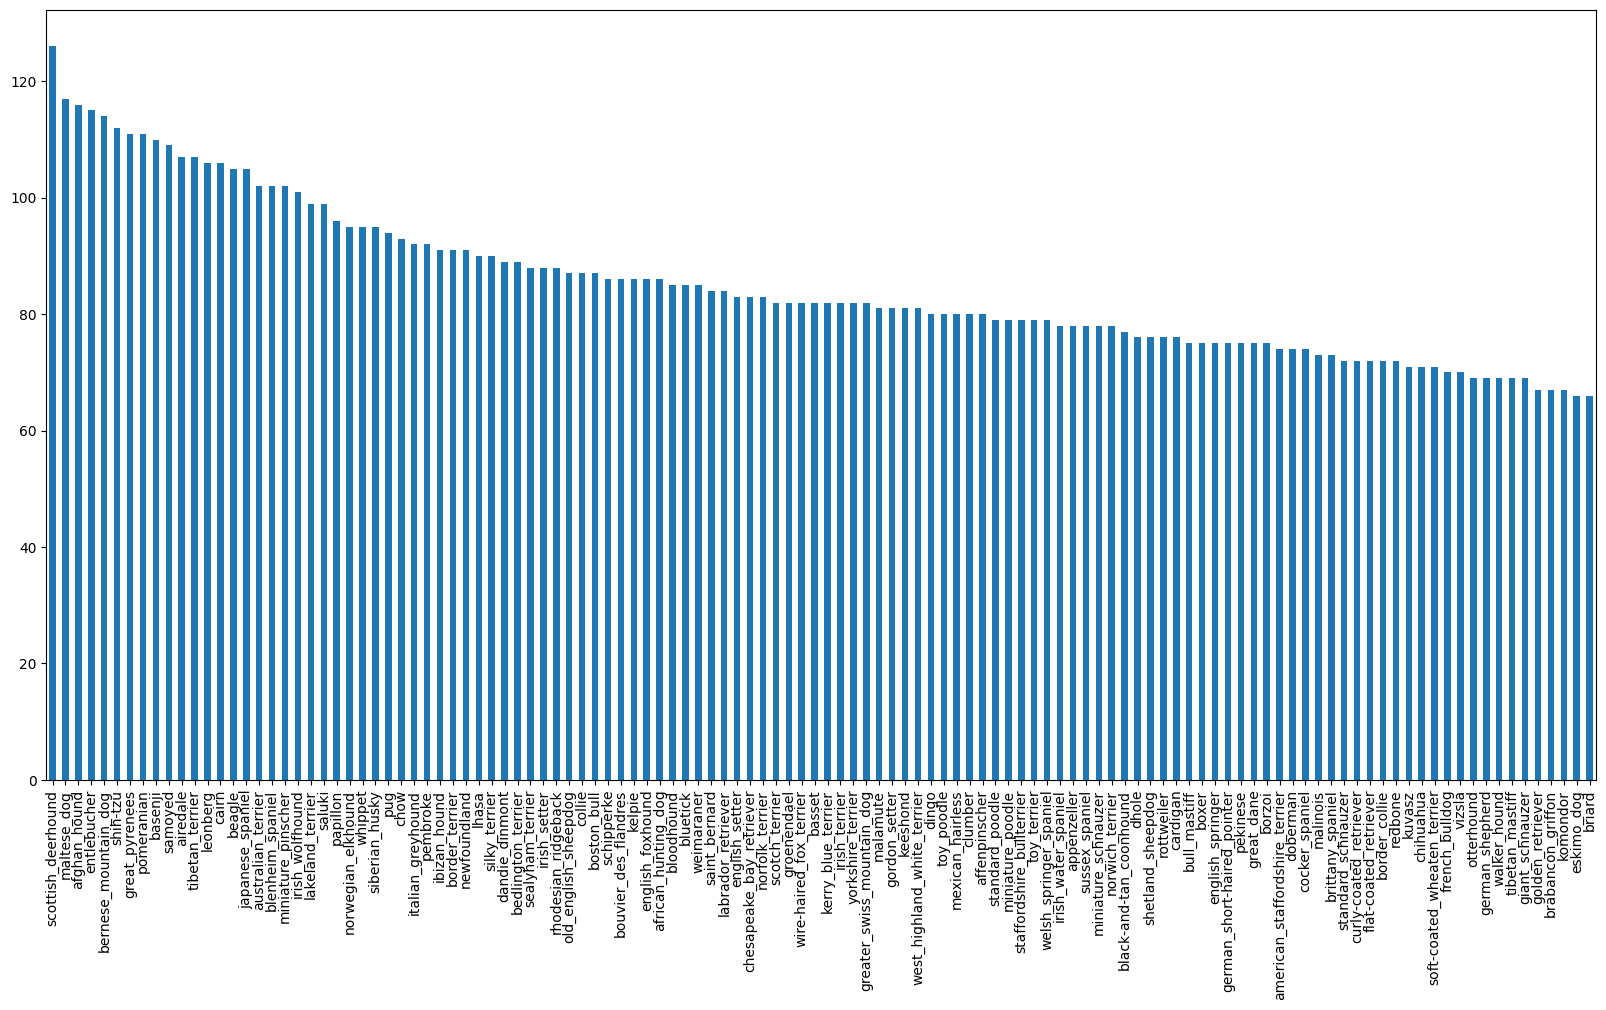

In [ ]:
print("median breed count : " , labels_csv.breed.value_counts().median(),"\n\n\n")
labels_csv.breed.value_counts().plot.bar(figsize=(20,10));

In [ ]:
import os
# print(len(os.listdir("/content/drive/MyDrive/CanineID/test"))) -------->10357 images for testing
# print(len(os.listdir("/content/drive/MyDrive/CanineID/train"))) -------->10222 images for training

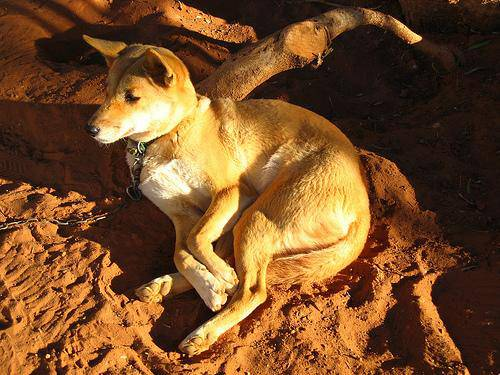

In [ ]:
from IPython.display import Image
Image("/content/drive/MyDrive/CanineID/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg")

In [ ]:
# Path of all image
filenames=["/content/drive/MyDrive/CanineID/train/"+fname+".jpg" for fname in labels_csv.id]
filenames[:5]

['/content/drive/MyDrive/CanineID/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '/content/drive/MyDrive/CanineID/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '/content/drive/MyDrive/CanineID/train/001cdf01b096e06d78e9e5112d419397.jpg',
 '/content/drive/MyDrive/CanineID/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '/content/drive/MyDrive/CanineID/train/0021f9ceb3235effd7fcde7f7538ed62.jpg']

In [ ]:
import numpy as np
breeds=np.array(labels_csv.breed)
unique_breeds=np.unique(breeds)
print(len(unique_breeds))
len(breeds)

120


10222

In [ ]:
boolean_labels=[breed==unique_breeds for breed in breeds]
boolean_labels[:5]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [ ]:
x=filenames # data
y=boolean_labels # labels

In [ ]:
# creating validation set
NUM_IMAGE=1000 #@param{type:"slider", min:1000,max:100000,step:1000}

In [ ]:
x=filenames
y=boolean_labels
from sklearn.model_selection import train_test_split
x_train ,  x_val , y_train , y_val = train_test_split(x[:NUM_IMAGE],
                                                        y[:NUM_IMAGE],
                                                        test_size=0.2,
                                                        random_state=42)
len(x_train), len(x_val), len(y_val),len(y_train)

(800, 200, 200, 800)

In [ ]:
# Define image size
IMG_SIZE = 224

def process_image(image_path):
  """
  Takes an image file path and turns it into a Tensor.
  """
  # Read in image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the colour channel values from 0-225 values to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired size (224, 244)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
  return image


In [ ]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the associated label,
  processes the image and returns a tuple of (image, label).
  """
  image = process_image(image_path)
  return image, label

In [ ]:
# Define the batch size, 32 is a good default
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (x) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle it if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x))) # only filepaths
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # If the data if a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    # If the data is a training dataset, we shuffle it
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                              tf.constant(y))) # labels

    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(x))

    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

In [ ]:
# Create training and validation data batches
train_data = create_data_batches(x_train, y_train)
val_data = create_data_batches(x_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [ ]:
# different attribute of data batches
train_data.element_spec , val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

In [ ]:

train_images, train_labels = next(train_data.as_numpy_iterator())

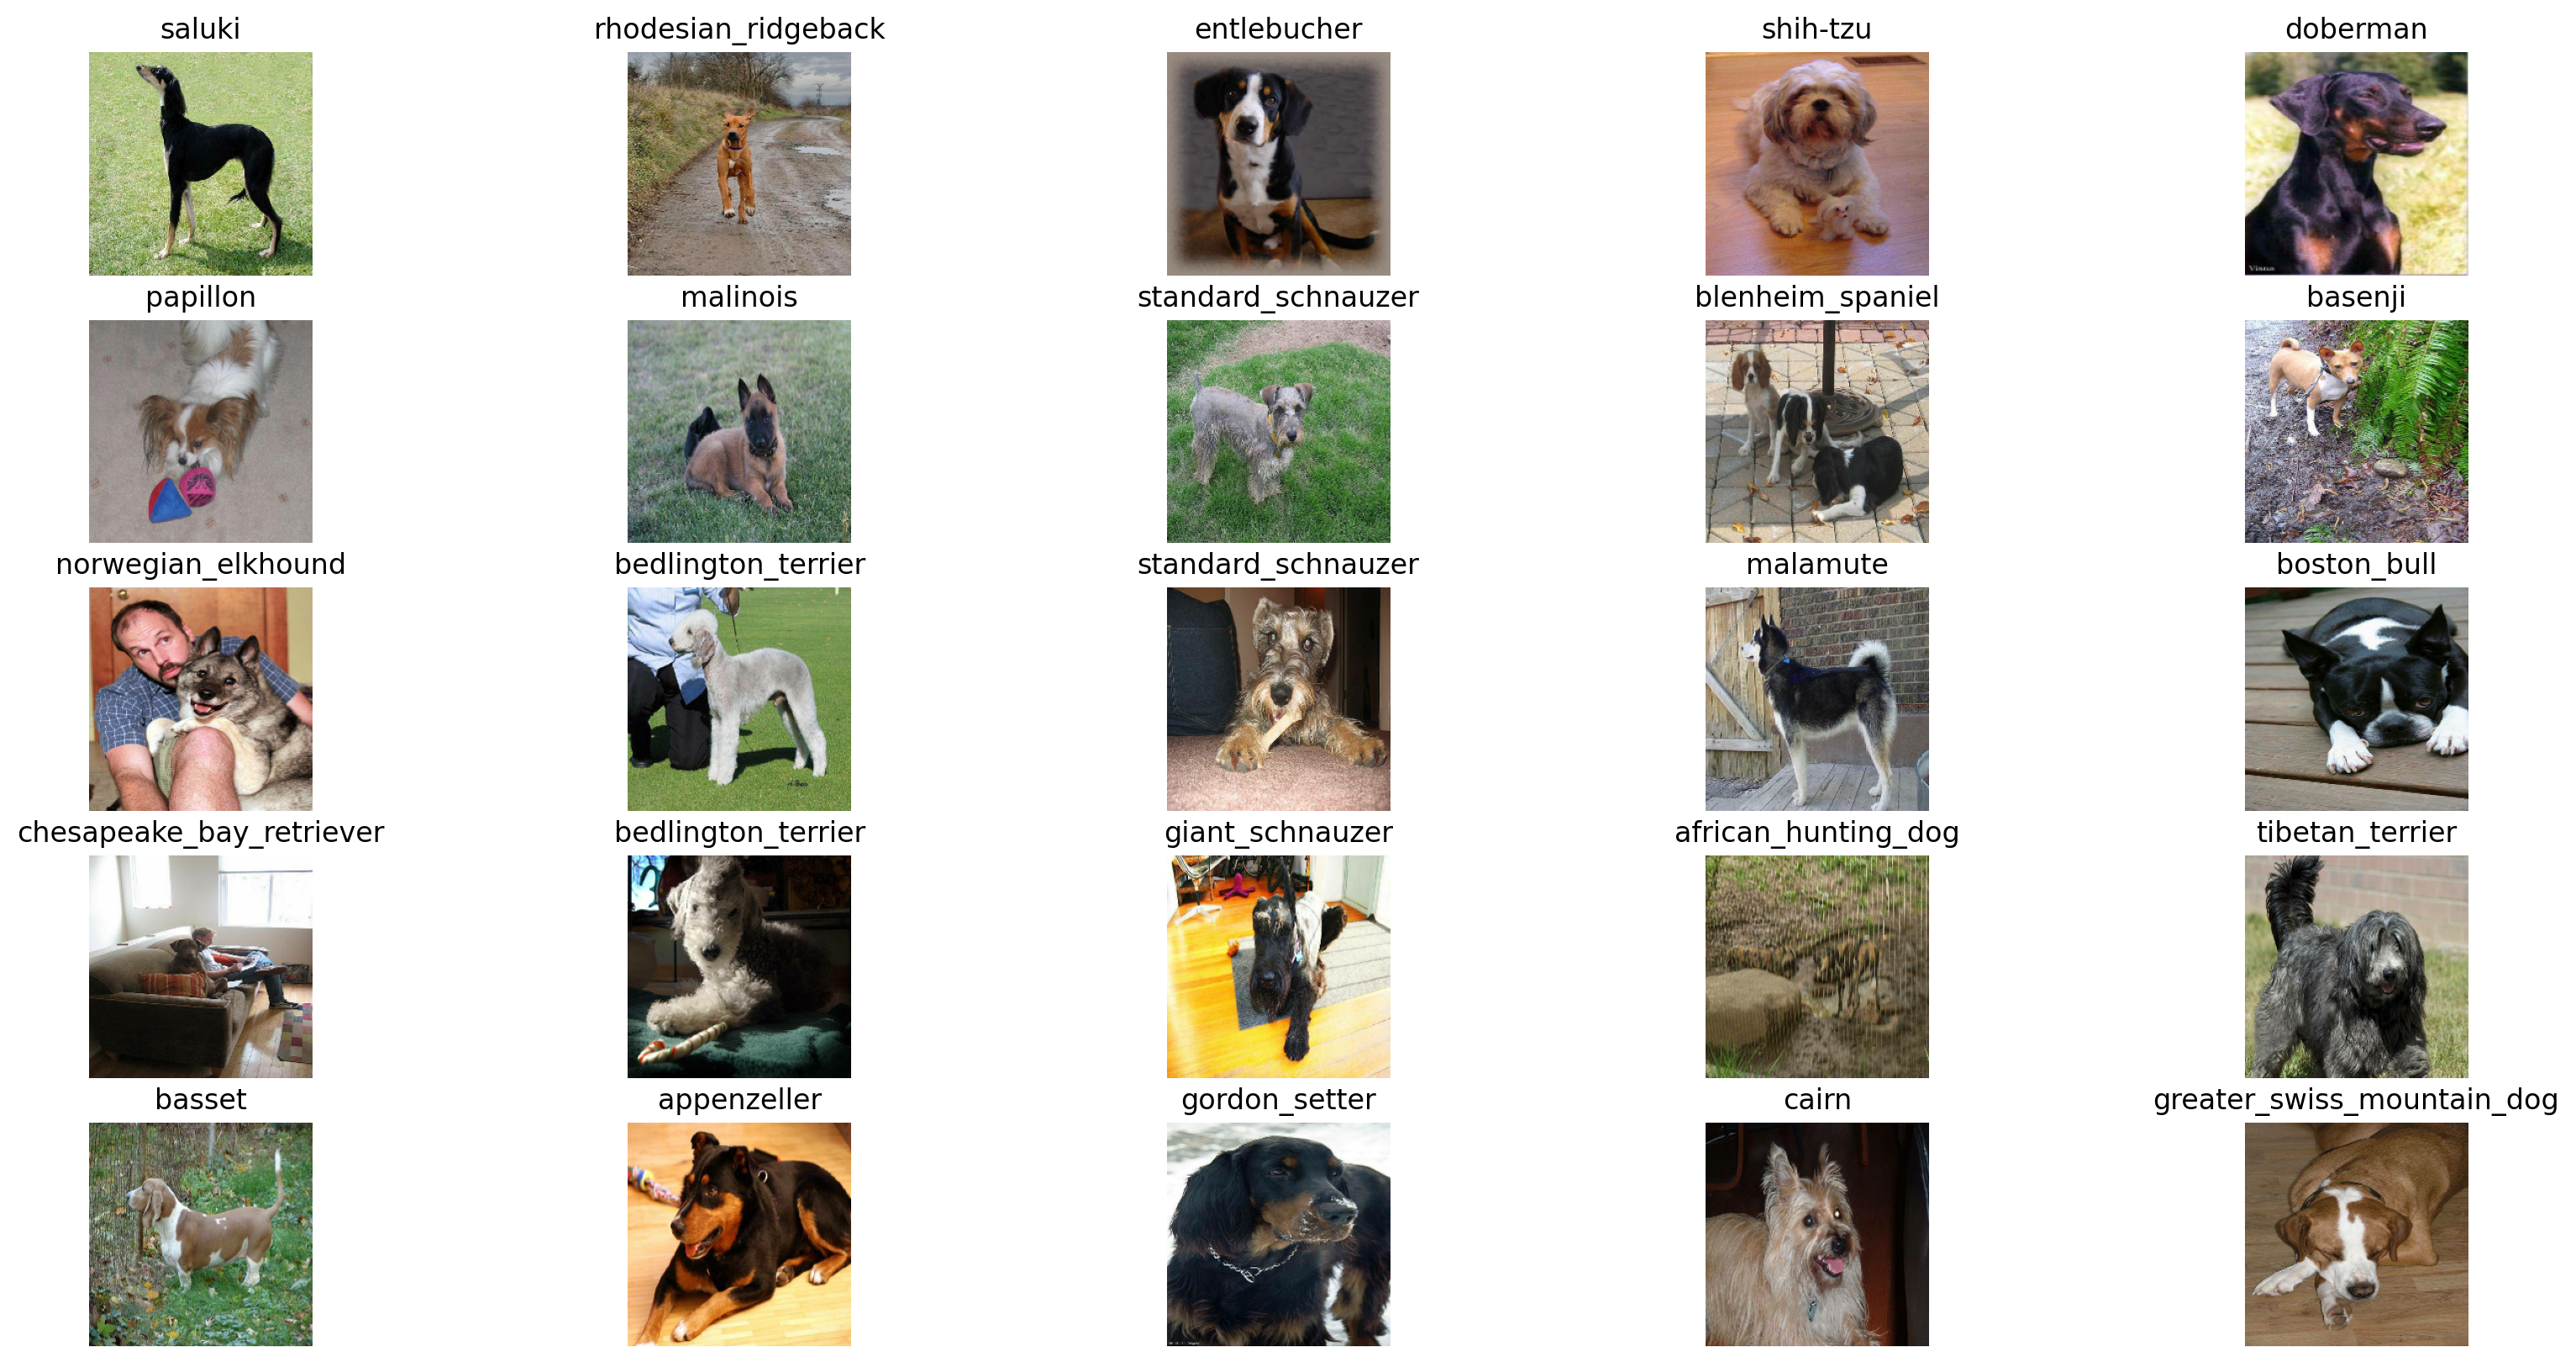

In [ ]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays 25 images from a data batch.
  """
  # Setup the figure
  plt.figure(figsize=(20, 10),dpi=200)
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn gird lines off
    plt.axis("off")
    plt.tight_layout

show_25_images(train_images,train_labels)

In [ ]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channels

# Setup output shape of the model
OUTPUT_SHAPE = len(unique_breeds) # number of unique labels

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

In [ ]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)

  # Setup the model layers
  model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
    tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                          activation="softmax") # Layer 2 (output layer)
  ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(), # Our model wants to reduce this (how wrong its guesses are)
      optimizer=tf.keras.optimizers.Adam(), # A friend telling our model how to improve its guesses
      metrics=["accuracy"] # We'd like this to go up
  )

  # Build the model
  model.build(INPUT_SHAPE) # Let the model know what kind of inputs it'll be getting

  return model

In [ ]:
# Create a model and check its details
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 5552953 (21.18 MB)
Trainable params: 120240 (469.69 KB)
Non-trainable params: 5432713 (20.72 MB)
_________________________________________________________________


In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("drive/My Drive/Data/logs",
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)


In [ ]:
import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("drive/My Drive/Data/logs",
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

In [ ]:
# Create early stopping (once our model stops improving, stop training)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3) # stops after 3 rounds of no improvements


In [ ]:
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}

In [ ]:
def train_model():
  """
  Trains a given model and returns the trained version.
  """
  # Create a model
  model = create_model()

  # Create new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1, # check validation metrics every epoch
            callbacks=[tensorboard, early_stopping])

  return model

In [ ]:
model = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/100
25/25 [==============================] - 134s 5s/step - loss: 4.5721 - accuracy: 0.1025 - val_loss: 3.3969 - val_accuracy: 0.2650
Epoch 2/100
25/25 [==============================] - 4s 155ms/step - loss: 1.6242 - accuracy: 0.7013 - val_loss: 2.1300 - val_accuracy: 0.5100
Epoch 3/100
25/25 [==============================] - 4s 172ms/step - loss: 0.5572 - accuracy: 0.9413 - val_loss: 1.6542 - val_accuracy: 0.6200
Epoch 4/100
25/25 [==============================] - 5s 190ms/step - loss: 0.2519 - accuracy: 0.9837 - val_loss: 1.5045 - val_accuracy: 0.6300
Epoch 5/100
25/25 [==============================] - 4s 170ms/step - loss: 0.1478 - accuracy: 0.9950 - val_loss: 1.4189 - val_accuracy: 0.6250
Epoch 6/100
25/25 [==============================] - 4s 148ms/step - loss: 0.1009 - accuracy: 1.0000 - val_loss: 1.3817 - val_accuracy: 0.6500
Epoch 7/100
25/25 [==============================]

In [ ]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(val_data, verbose=1) # verbose shows us how long there is to go
predictions# Make predictions on the validation data (not used to train on)

7/7 [==============================] - 2s 164ms/step


array([[6.73187710e-03, 3.80186801e-04, 1.34176237e-03, ...,
        6.09010785e-05, 5.75680569e-05, 2.40548677e-03],
       [3.55897169e-03, 1.75030192e-03, 8.71187076e-03, ...,
        4.47721424e-04, 5.03298640e-03, 1.95632121e-04],
       [3.06989864e-06, 4.69354214e-04, 1.31780780e-05, ...,
        8.11913924e-05, 1.11495965e-05, 7.52409396e-05],
       ...,
       [3.08024901e-05, 3.99078235e-05, 2.51010169e-05, ...,
        7.41280601e-05, 3.99687095e-04, 2.30283986e-04],
       [8.46797891e-04, 2.81835033e-04, 8.12765065e-05, ...,
        2.79462074e-05, 7.66017838e-05, 6.50238758e-03],
       [6.91462774e-04, 6.01900792e-05, 7.57615198e-04, ...,
        1.51622866e-03, 7.79396389e-04, 2.25903917e-04]], dtype=float32)

In [ ]:
# Check the shape of predictions
predictions.shape

(200, 120)

In [ ]:
# First prediction
print(predictions[0])
print(f"Max value (probability of prediction): {np.max(predictions[0])}") # the max probability value predicted by the model
print(f"Sum: {np.sum(predictions[0])}") # because we used softmax activation in our model, this will be close to 1
print(f"Max index: {np.argmax(predictions[0])}") # the index of where the max value in predictions[0] occurs
print(f"Predicted label: {unique_breeds[np.argmax(predictions[0])]}") # the predicted label

[6.73187710e-03 3.80186801e-04 1.34176237e-03 1.05177067e-04
 2.82179302e-04 2.80424410e-05 4.93112244e-02 2.67739710e-03
 5.09996782e-04 6.56193530e-04 3.03707580e-04 9.50449787e-04
 1.58615105e-04 1.31776673e-04 5.51700476e-04 4.59189090e-04
 6.80045632e-05 1.76633924e-01 2.84411562e-05 6.77957651e-05
 2.50593526e-03 4.15066927e-04 6.13886505e-06 4.04625246e-03
 2.70121145e-05 5.02494804e-04 1.13538280e-01 1.15633557e-04
 1.48796488e-03 5.69282798e-04 1.11197820e-03 2.33826018e-03
 9.33636737e-04 1.55786438e-05 3.03048495e-04 4.34658565e-02
 5.95130859e-06 1.70391955e-04 8.48351483e-05 1.81208652e-05
 2.13092985e-03 2.19309950e-05 5.07314224e-04 3.70526337e-04
 5.41834852e-05 2.81539280e-04 8.50428842e-05 1.47957669e-03
 4.15597140e-04 2.89800868e-04 1.97401736e-04 7.46172082e-05
 2.45758193e-03 1.18402757e-04 3.17904807e-04 8.07237302e-05
 1.10983958e-04 2.15890212e-03 2.57677195e-04 1.78286359e-01
 7.25499936e-04 2.44355062e-04 4.21351084e-04 1.48828058e-05
 1.05041184e-03 3.586174

In [ ]:
# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[0])
pred_label

'irish_wolfhound'

In [ ]:
# Create a function to unbatch a batched dataset
def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors and returns separate arrays
  of images and labels.
  """
  images = []
  labels = []
  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images, labels

# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.27701408, 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

In [ ]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth label and image for sample n.
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get the pred label
  pred_label = get_pred_label(pred_prob)

  # Plot image & remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the color of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  plt.title("{} {:2.0f}% ({})".format(pred_label,
                                      np.max(pred_prob)*100,
                                      true_label),
                                      color=color)

In [ ]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plots the top 10 highest prediction confidences along with
  the truth label for sample n.
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  # Find the top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")

  # Change color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

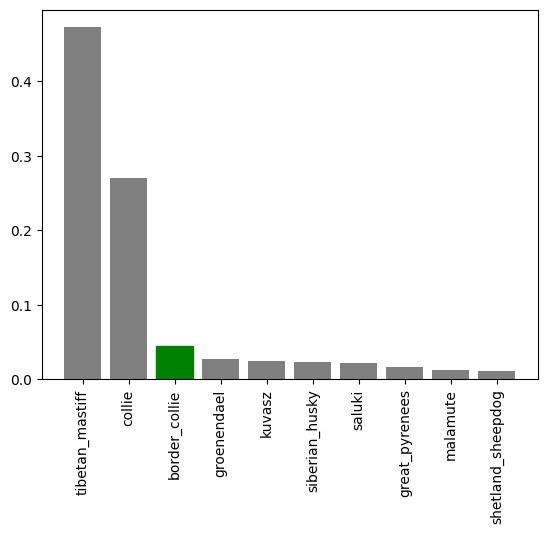

In [ ]:
plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,
               n=9)

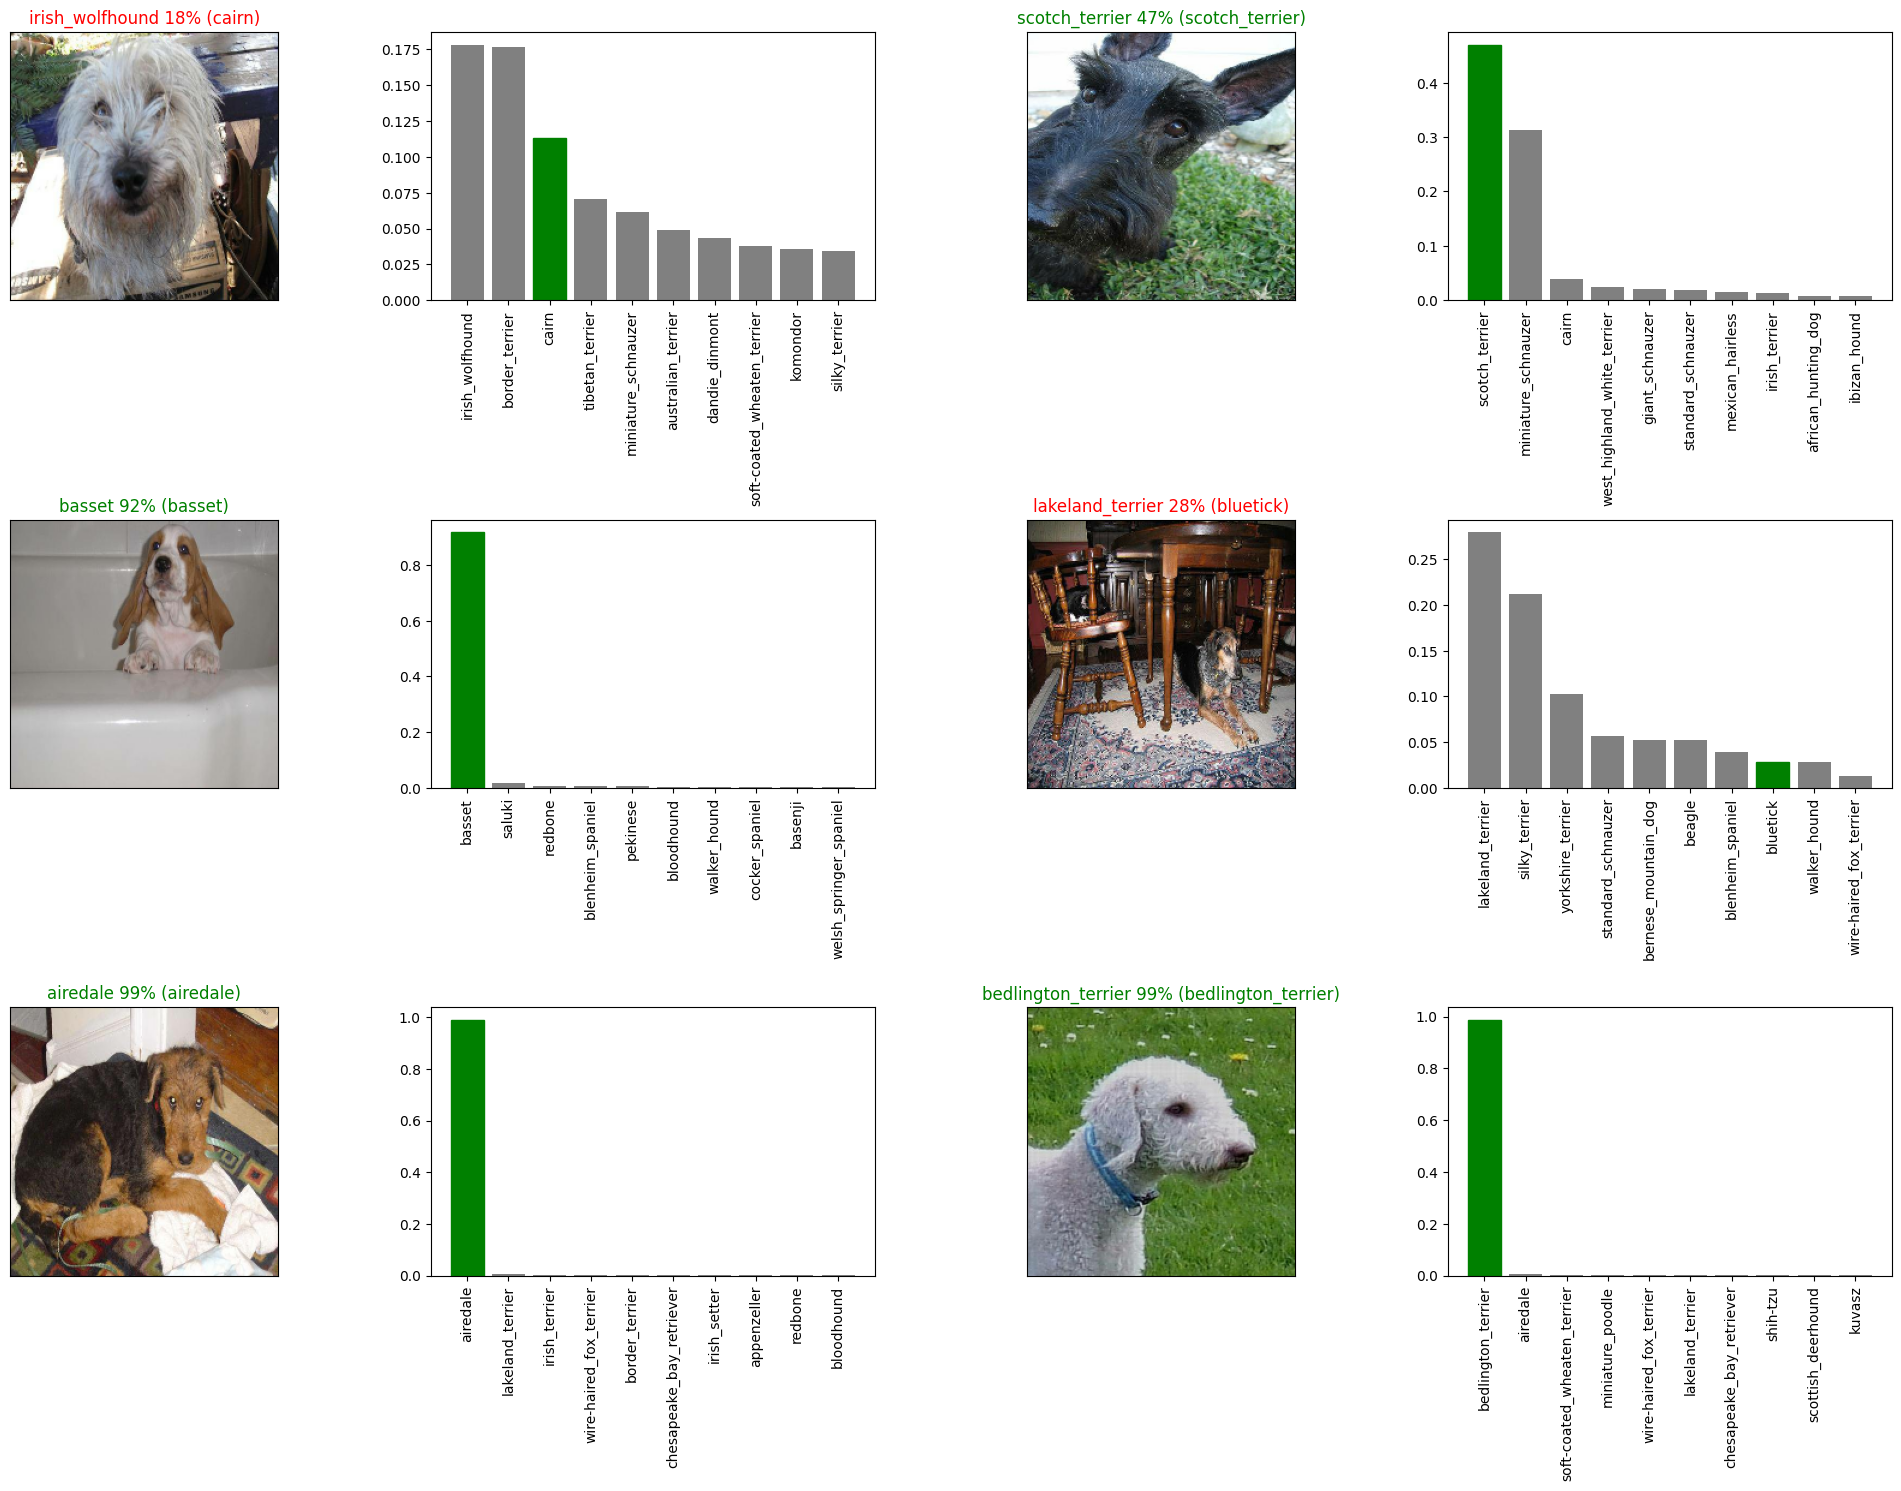

In [ ]:
# Let's check a few predictions and their different values
i_multiplier = 0
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(5*2*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                labels=val_labels,
                n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

In [ ]:
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (str)
  for clarity and reuse.
  """
  # Create model directory with current time
  modeldir = os.path.join("/content/drive/MyDrive/CanineID/Model",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

In [ ]:
full_data = create_data_batches(x, y)

Creating training data batches...


In [ ]:
full_model = create_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


In [ ]:
full_model_tensorboard = create_tensorboard_callback()

# Early stopping callback
# Note: No validation set when training on all the data, therefore can't monitor validation accruacy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=3)

In [ ]:
save_model(model, suffix="1000-images-Adam")

Saving model to: /content/drive/MyDrive/CanineID/Model/20240302-10421709376147-1000-images-Adam.h5...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


'/content/drive/MyDrive/CanineID/Model/20240302-10421709376147-1000-images-Adam.h5'

In [ ]:
loaded_full_model = load_model("/content/drive/MyDrive/CanineID/Model/20240302-10421709376147-1000-images-Adam.h5")

Loading saved model from: /content/drive/MyDrive/CanineID/Model/20240302-10421709376147-1000-images-Adam.h5


In [ ]:
# Evalutating Pre-Saved Model
model.evaluate(val_data)

7/7 [==============================] - 1s 102ms/step - loss: 1.2679 - accuracy: 0.6500


[1.2678879499435425, 0.6499999761581421]

In [ ]:
loaded_full_model.evaluate(val_data)

7/7 [==============================] - 2s 153ms/step - loss: 1.2679 - accuracy: 0.6500


[1.2678879499435425, 0.6499999761581421]